# Compile Tuned models

We grab the tuned models (performed using the Levenberg Marquadt algorithm on the Sciama HPC).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import json
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from gzbuilder_analysis.parsing import unmake_json
from gzbuilder_analysis.fitting import Model, loss, chisq
import lib.galaxy_utilities as gu

In [3]:
AGG_MODEL_PATH = 'output_files/tuned_models/agg'
BI_MODEL_PATH = 'output_files/tuned_models/bi'

In [4]:
diff_data_df = pd.read_pickle('lib/fitting_metadata.pkl')

In [5]:
def make_model(subject_id, m):
    psf = gu.get_psf(subject_id)
    dd = diff_data_df.loc[subject_id]
    pixel_mask = dd['pixel_mask'][::-1]
    galaxy_data = dd['galaxy_data'][::-1]
    sigma_image = dd['sigma_image'][::-1]
    return Model(
        m, galaxy_data, psf=psf,
        pixel_mask=pixel_mask, sigma_image=sigma_image
    )

In [6]:
available_agg_models = [
    i for i in os.listdir(AGG_MODEL_PATH)
    if re.match(r'[0-9]+\.json', i)
]
available_bi_models = [
    i for i in os.listdir(BI_MODEL_PATH)
    if re.match(r'[0-9]+\.json', i)
]

Note that below, "loss" is $\chi_\nu^2$, as we have provided a sigma image, otherwise it would be `mean_squared_error` (MSE). 

$$\chi_\nu^2 =\frac{1}{N_\mathrm{dof}}\sum_{x=1}^{nx}\sum_{y=1}^{ny}\frac{\left(f_\mathrm{data}(x, y) - f_\mathrm{model}(x, y)\right)^2}{\sigma(x, y)^2}$$

$\chi_\nu^2$ is independent of scaling as we divide by the variance.

As the original data was scaled to be between 0 and 1, we should reverse that scaling before quoting MSE:

$$L_\mathrm{scaled} = (y - Y)^2 / N$$

$$L =\frac{1}{N}(sy - sY)^2 = \frac{s^2(y - Y)^2}{N}$$

$$L = s^2L_\mathrm{scaled}$$

Where $Y$ is the galaxy data, and $y$ is the rendered model

In [8]:
agg_models = pd.Series([])
agg_losses = pd.Series([]).rename('agg_loss')
with tqdm(available_agg_models, desc='Aggregate') as bar:
    for f in bar:
        subject_id = int(f.split('.')[0])
        with open(os.path.join(AGG_MODEL_PATH, f)) as f_in:
            model = unmake_json(json.load(f_in))
        model_obj = make_model(subject_id, model)
        r = model_obj.render()
        agg_models[subject_id] = model_obj
        agg_losses[subject_id] = loss(
            r,
            model_obj.data,
            pixel_mask=model_obj.pixel_mask,
            sigma_image=model_obj.sigma_image,
        )

Aggregate: 100%|██████████| 296/296 [02:56<00:00,  2.49it/s]


In [10]:
bi_models = pd.Series([])
bi_losses = pd.Series([]).rename('bi_loss')
with tqdm(available_bi_models, desc='Best Individual') as bar:
    for f in bar:
        subject_id = int(f.split('.')[0])
        with open(os.path.join(BI_MODEL_PATH, f)) as f_in:
            model = unmake_json(json.load(f_in))
        model_obj = make_model(subject_id, model)
        r = model_obj.render(model_obj._model)
        bi_models[subject_id] = model_obj
        bi_losses[subject_id] = loss(
            r,
            model_obj.data,
            pixel_mask=model_obj.pixel_mask,
            sigma_image=model_obj.sigma_image,
        )

Best Individual: 100%|██████████| 296/296 [02:56<00:00,  2.49it/s]


In [11]:
print('Saving fitted models')
fitted_models = pd.DataFrame([], columns=('agg', 'bi', 'agg_loss', 'bi_loss'))
for i in bi_models.index:
  fitted_models.loc[i] = dict(
    agg=agg_models.loc[i]._model,
    bi=bi_models.loc[i]._model,
    agg_loss=agg_losses.loc[i],
    bi_loss=bi_losses.loc[i],
  )
fitted_models.to_pickle('lib/fitted_models.pickle')

Saving fitted models


Let's have a look at a selection of residuals:

In [12]:
model_data = agg_models.apply(lambda m: np.nanprod((m.data, m.pixel_mask), axis=0))
residuals = agg_models.apply(lambda m: np.nanprod((
    m.cached_render(m._model) / 0.8 - m.data,
    m.pixel_mask
), axis=0))
multipliers = pd.Series(
    residuals.index,
    index=residuals.index
).apply(lambda i: gu.get_diff_data(i)['multiplier'])

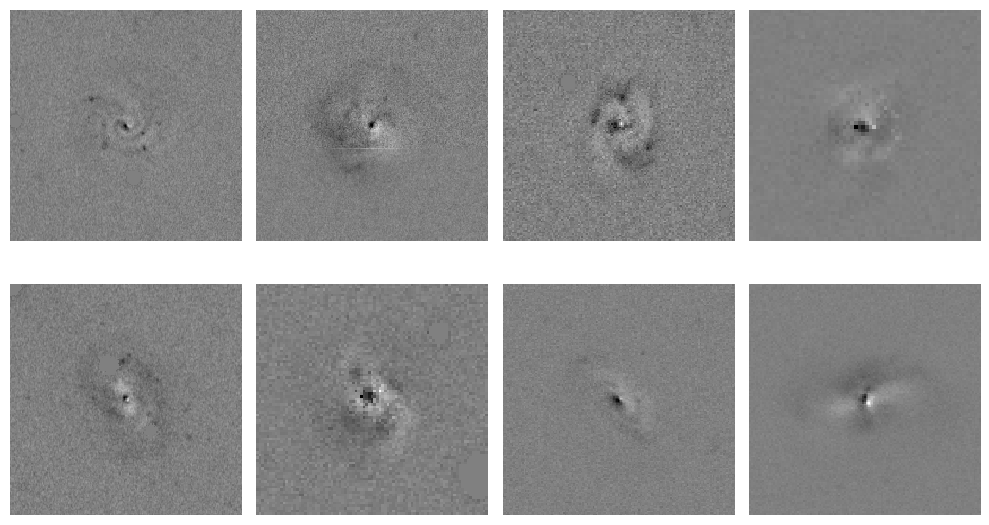

In [13]:
f, axs = plt.subplots(nrows=2, ncols=4, figsize=(10, 6), dpi=100)
# example indices
idxs = [21096864, 21686503, 20902009, 21686601, 21096948, 21686589,
       21686560, 20902038]
for i, ax in enumerate(j for i in axs for j in i):
  sid = idxs[i]
  r = residuals.loc[sid] * multipliers.loc[sid]
  l = np.abs(r).max()
  ax.imshow(r, vmin=-l, vmax=l, cmap='gray')
  ax.axis('off')
plt.tight_layout()

Text(0.5, 1.0, 'Tuned Agg loss: 4.9225e+00')

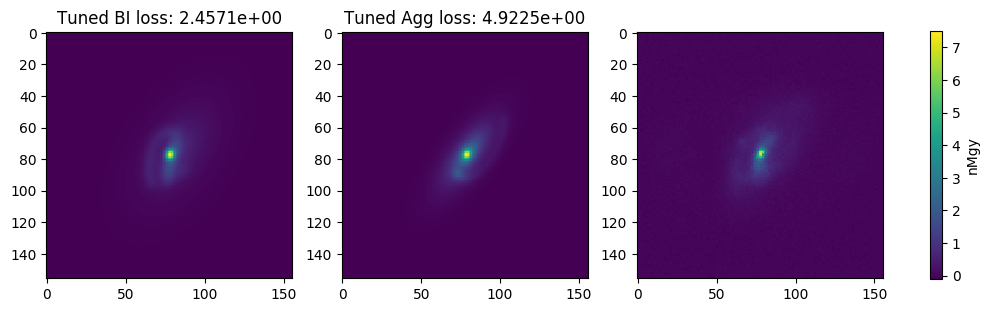

In [14]:
m = gu.get_diff_data(bi_models.index[13])['multiplier']
f, ax = plt.subplots(ncols=3, figsize=(12, 4), dpi=100)
ax[0].imshow(bi_models.iloc[13].render() * m / 0.8)
ax[1].imshow(agg_models.iloc[13].render() * m / 0.8)
m = ax[2].imshow(bi_models.iloc[13].data * m)
c = plt.colorbar(m, ax=ax, shrink=0.82, fraction=0.05)
c.set_label('nMgy')
ax[0].set_title('Tuned BI loss: {:.4e}'.format(bi_losses.iloc[13]))
ax[1].set_title('Tuned Agg loss: {:.4e}'.format(agg_losses.iloc[13]))

And how does the tuned best individual stack up against the tuned aggregate?

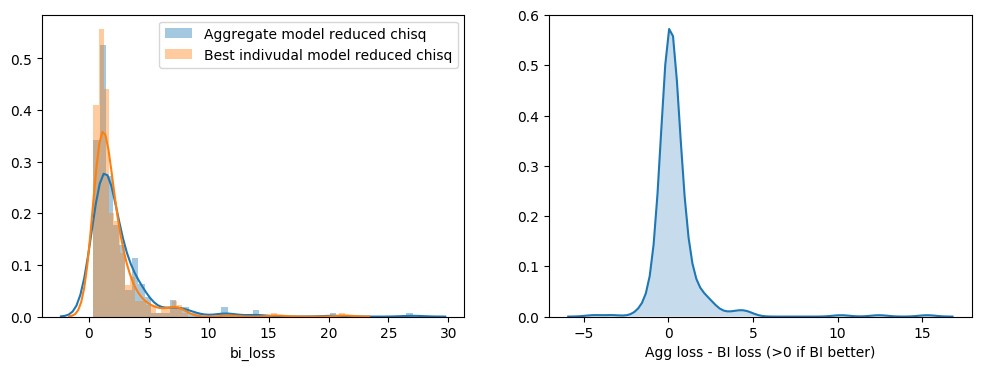

In [80]:
_, axs = plt.subplots(ncols=2, figsize=(12, 4), dpi=100)
plt.sca(axs[0])
sns.distplot(agg_losses, label='Aggregate model reduced chisq')
sns.distplot(bi_losses, label='Best indivudal model reduced chisq')
plt.legend()
plt.sca(axs[1])
diff = agg_losses - bi_losses
sns.kdeplot(diff.dropna(), shade=True)
plt.xlabel('Agg loss - BI loss (>0 if BI better)')
l = plt.ylim()[1]
plt.ylim(0, l);

Who wins (and with what probability)? Note we define winning as having the lower reduced chisq,even though this is not always desirable.

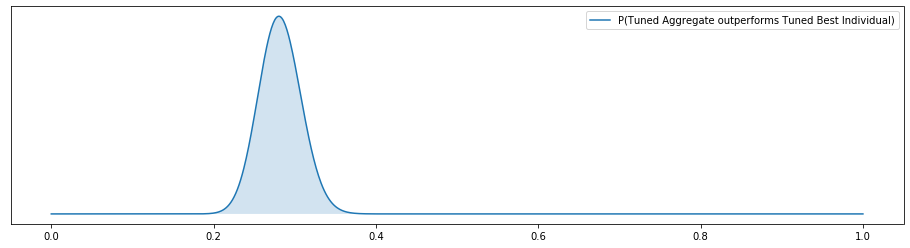

In [17]:
x = np.linspace(0, 1, 1000)
p_agg_better = st.beta.pdf(x, 1 + (diff < 0).sum(), 1 + len(diff) - (diff < 0).sum())
plt.figure(figsize=(16, 4))
plt.plot(x, p_agg_better, label='P(Tuned Aggregate outperforms Tuned Best Individual)')
plt.fill_between(x, 0, p_agg_better, alpha=0.2)
plt.legend()
plt.yticks([]);

What do the models look like where the differences between aggregate and models are largest?

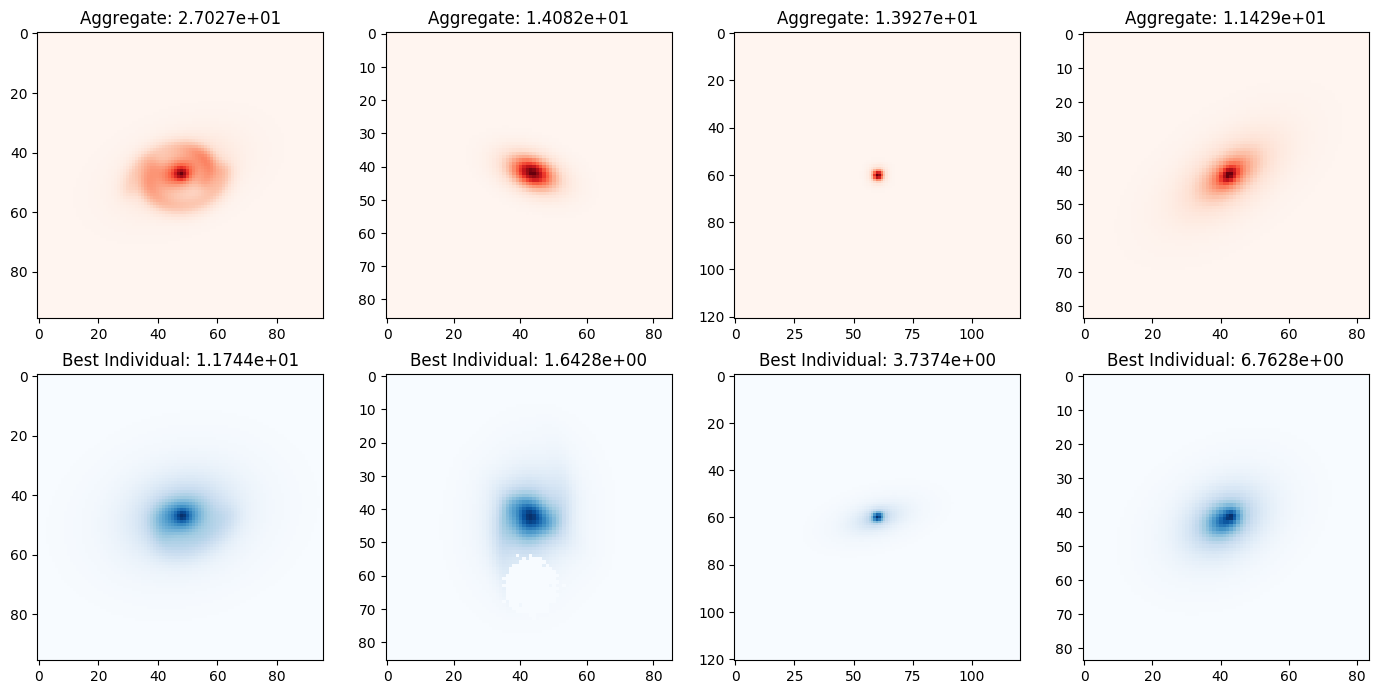

In [18]:
_, ax = plt.subplots(nrows=2, ncols=4, figsize=(14, 7), dpi=100)
for i, idx in enumerate(diff.abs().sort_values(ascending=False).index[:4]):
  agg_better = agg_losses.loc[idx] < bi_losses.loc[idx]
  a = agg_models.loc[idx]
  b = bi_models.loc[idx]
  ax[0][i].imshow(a.render() * a.pixel_mask ,
                  cmap=('Blues' if agg_better else 'Reds'))
  ax[0][i].set_title('Aggregate: {:.4e}'.format(agg_losses.loc[idx]))
  ax[1][i].imshow(b.render() * b.pixel_mask,
                  cmap=('Reds' if agg_better else 'Blues'))
  ax[1][i].set_title('Best Individual: {:.4e}'.format(bi_losses.loc[idx]))
plt.tight_layout()

We see that the aggregate sometimes loses the secondary components which allow the best individual to properly account for the internal structure of the galaxy.

Does our value for chi-square vary with the resolution of the image?

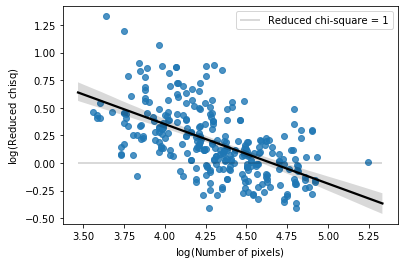

In [132]:
sns.regplot(
    np.log10(bi_models.apply(lambda a: a.data[
        a.pixel_mask.astype(bool)
    ].size)),
    np.log10(bi_losses),
    line_kws=dict(color='k')
)
plt.hlines(0, *plt.xlim(), alpha=0.2, label='Reduced chi-square = 1')
plt.legend()
plt.xlabel('$\log(\mathrm{Number\ of\ pixels})$')
plt.ylabel('$\log(\mathrm{Reduced\ chisq})$');

Interesting. Digging further we see this is more to do with the petrosean radius of the image than the redshift, suggesting it really is that we need more pixels to get a good model using our method:

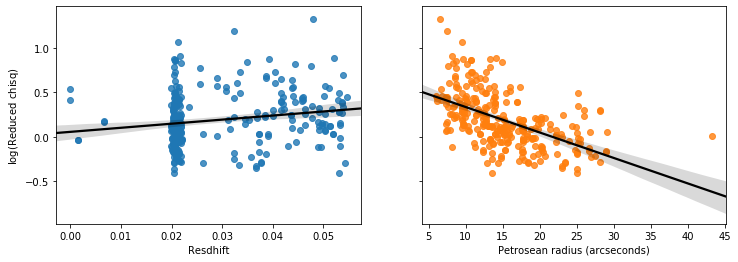

In [135]:
_, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
plt.sca(ax[0])
sns.regplot(
    gu.metadata['redshift'].apply(float).dropna().reindex_like(bi_losses),
    np.log10(bi_losses),
    line_kws=dict(color='k')
)
plt.xlabel('Resdhift')
plt.ylabel('$\log(\mathrm{Reduced\ chisq})$')
plt.sca(ax[1])
sns.regplot(
    gu.metadata['Petrosian radius (degrees)'].apply(float).dropna().reindex_like(bi_losses),
    np.log10(bi_losses),
    color='C1',
    line_kws=dict(color='k')
)
plt.xlabel('Petrosean radius (arcseconds)')
plt.ylabel(None);

How do the residuals measure up? As well as obtaining a likelihood for our models, we can measure what proportion of light has been accounted for

$$R_\mathrm{max} = \frac{\max(|D_i - M_i|)}{\mathrm{max}(D_i)}$$
$$R_\mathrm{sum} = \frac{\sum_{i=0}^N|D_i - M_i|}{\sum_{i=0}^N|D_i|}$$

Text(0.5, 0, 'upper 90th percentile value')

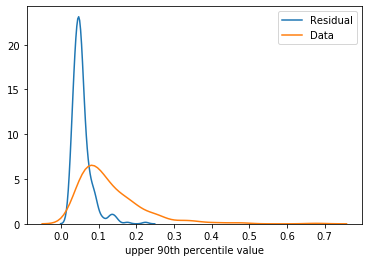

In [50]:
sns.kdeplot(
    (residuals * multipliers).apply(
        lambda m: np.percentile(np.abs(m), 90)
    ).rename('Residual')
)
sns.kdeplot(
    (model_data * multipliers).apply(
        lambda m: np.percentile(np.abs(m), 90)
    ).rename('Data')
)
((residuals * multipliers).apply(
        lambda m: np.percentile(np.abs(m), 90)
) / (model_data * multipliers).apply(
    lambda m: np.percentile(np.abs(m), 90)
)).describe()
plt.xlabel('upper 90th percentile value')

Text(0.5, 0, 'Mean pixel value')

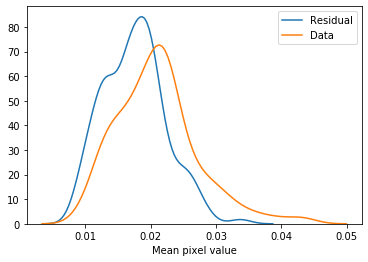

In [51]:
residual_median = (residuals * multipliers).apply(lambda m: np.median(np.abs(m)))
data_median = (model_data * multipliers).apply(lambda m: np.median(np.abs(m)))
sns.kdeplot(residual_median.rename('Residual'))
sns.kdeplot(data_median.rename('Data'))
(residual_median / data_median).describe()
plt.xlabel('Mean pixel value')

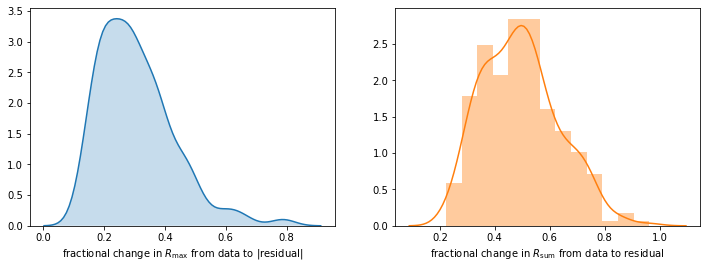

In [56]:
residual_max = (residuals * multipliers).apply(lambda m: np.max(np.abs(m)))
residual_sum = (residuals * multipliers).apply(lambda m: np.sum(np.abs(m)))
model_sum = (model_data * multipliers).apply(lambda m: np.sum(np.abs(m)))
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.xlabel('fractional change in $R_\mathrm{max}$ from data to |residual|')
sns.kdeplot(residual_max / multipliers, shade=True)
plt.subplot(122)
plt.xlabel('fractional change in $R_\mathrm{sum}$ from data to residual')
sns.distplot(residual_sum / model_sum, color='C1')

In [23]:
display((residual_max / multipliers).describe().rename('Max pivot'))
display((residual_sum / model_sum).describe().rename('Sum pivot'))

count    296.000000
mean       0.306787
std        0.123052
min        0.121809
25%        0.206951
50%        0.285567
75%        0.371374
max        0.793594
Name: Max pivot, dtype: float64

count    296.000000
mean       0.492776
std        0.138767
min        0.221938
25%        0.381900
50%        0.491806
75%        0.573722
max        0.963132
Name: Sum pivot, dtype: float64